In [1]:
#imports
import numpy as np
import pandas as pd
from itertools import chain
from matplotlib import pyplot as plt
import random
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
plt.style.use('seaborn')

In [2]:
#read CSVs
order_products_prior = pd.read_csv('data/order_products__prior.csv')
order_products_train = pd.read_csv('data/order_products__train.csv')
products = pd.read_csv('data/products.csv')
departments = pd.read_csv('data/departments.csv')
aisles = pd.read_csv('data/aisles.csv')

order_products = pd.concat([order_products_prior,order_products_train])

In [3]:
#Downsampling
n_samples = 50000
ids_ = order_products.order_id.unique().tolist()
id_selected = random.sample(ids_,n_samples)
order_products_sr = order_products[order_products.order_id.isin(id_selected)]

In [4]:
pbu1 = order_products_sr.merge(products, on = 'product_id').sort_values(by = ['order_id','add_to_cart_order'])
pbu = pbu1.loc[:,['order_id','product_name']]
print(f'Rows: {pbu.shape[0]}')
pbu['product_name'] = pbu.product_name.str.strip().str.lower().str.split(' ')
pbu.head()

Rows: 506138


,order_id,product_name
0,110,"[organic, lemon]"
1339,110,"[organic, unsweetened, almond, milk]"
2224,110,"[beef, top, round, steak]"
2229,110,[cotija]
2244,110,"[organic, red, radish,, bunch]"


In [5]:
%%time
id_list = pbu.order_id.unique()
prods = [list(chain(*pbu.product_name[pbu.order_id == x].to_list())) for x in id_list]
listed_products = pd.DataFrame(list(zip(id_list,prods)),columns = ['order_id','products'])

Wall time: 1min 48s


In [6]:
print(f'Rows: {listed_products.shape[0]}')
listed_products.order_id = listed_products.order_id.astype(str)
listed_products.head()

Rows: 50000


,order_id,products
0,110,"[organic, lemon, organic, unsweetened, almond,..."
1,183,"[black, tea, variety, pack, assorted, herbal, ..."
2,208,"[masa, harina, golden, corn, flour, spanish, s..."
3,291,"[organic, seaweed, gomasio, turkey, pot, pie, ..."
4,429,"[coppertop, aa, batteries, gel, hand, wash, re..."


In [7]:
%%time
#training model
tagged_products = listed_products.values.tolist()
products_by_user = [TaggedDocument(products, [order_id]) for order_id, products in tagged_products]

d2v_model = Doc2Vec(documents = products_by_user,
                    vector_size = 25,
                    min_count = 100,
                    sample = 1e-2
                   )

# comparing similarity
sample_ = str(id_selected[0])
return_3 = d2v_model.docvecs.most_similar([d2v_model[sample_]])[:4]
print(return_3)

[('813277', 1.0), ('178255', 0.9699269533157349), ('636846', 0.9659625291824341), ('819125', 0.964790940284729)]
Wall time: 44.7 s


In [8]:
pbu1 = pbu1[['order_id','product_name']]
sample  = pbu1[pbu1.order_id == int(return_3[0][0])]
compare1 = pbu1[pbu1.order_id == int(return_3[1][0])]
compare2 = pbu1[pbu1.order_id == int(return_3[2][0])]

print('NUMBER OF ITEMS',
    '\nSample products: ',len(sample),
      '\nCompare products 1: ',len(compare1),
      '\nCompare products 2: ',len(compare2))

comp = sample.merge(compare1, on = 'product_name', how = 'outer')
comp = comp.merge(compare2, on = 'product_name', how = 'outer')
comp[['order_id_x','order_id_y','order_id','product_name']]

NUMBER OF ITEMS 
Sample products:  7 
Compare products 1:  17 
Compare products 2:  8


,order_id_x,order_id_y,order_id,product_name
0,813277.0,NaN,NaN,Sparkling Mineral Water
1,813277.0,NaN,NaN,Michigan Organic Kale
2,813277.0,NaN,NaN,Sparkling Natural Mineral Water
3,813277.0,NaN,NaN,Spring Water
4,813277.0,NaN,NaN,Organic California Style Sprouted Bread
5,813277.0,NaN,NaN,Organic Lemonade
6,813277.0,NaN,NaN,Italian Extra Virgin Olive Oil
7,NaN,178255.0,NaN,Sour Cream
8,NaN,178255.0,NaN,Pure Irish Butter
9,NaN,178255.0,NaN,Gluten Free Panko Breadcrumbs


## Elbow plot

In [9]:
%%time
distorsions = []
clusters = list(range(1,11))
for k in clusters:
    kmeans = KMeans(n_clusters= k, init='k-means++', max_iter=100)
    kmeans.fit(d2v_model.docvecs.vectors_docs)
    distorsions.append(kmeans.inertia_)

Wall time: 52 s


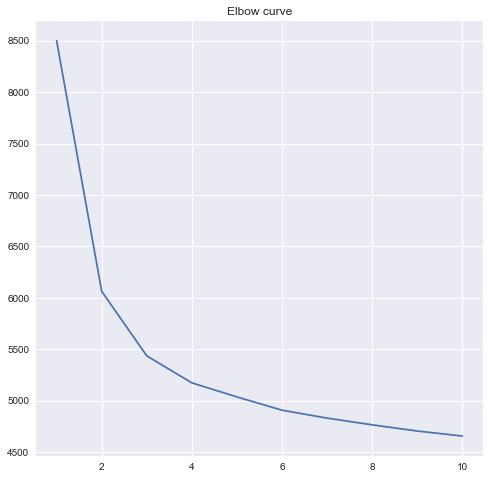

In [10]:
fig = plt.figure(figsize=(8, 8))
plt.plot(clusters, distorsions)
plt.title('Elbow curve')
plt.show()

## Clustering

In [11]:
n_clusters_ = 3
kmeans_model = KMeans(n_clusters=n_clusters_, init='k-means++', max_iter=100) 
X = kmeans_model.fit(d2v_model.docvecs.vectors_docs)
cluster_labels = kmeans_model.labels_
pca = PCA(n_components=2).fit(d2v_model.docvecs.vectors_docs)
datapoint = pca.transform(d2v_model.docvecs.vectors_docs)

## Representing groups

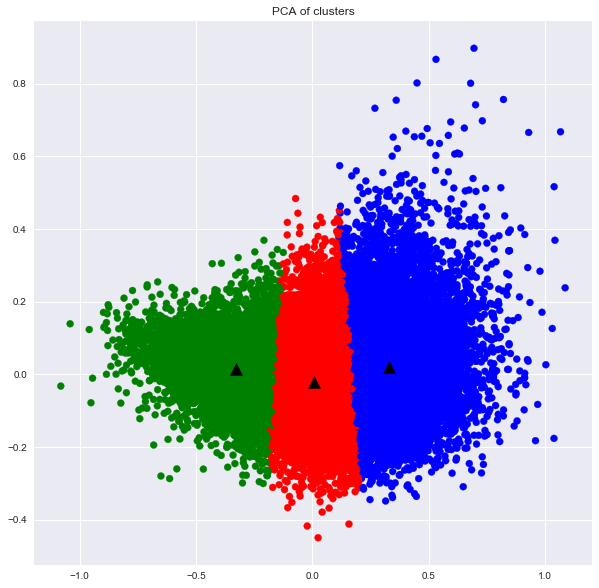

In [12]:
fig = plt.figure(figsize=(10, 10))
label1 = ['r','g','b','y']
color = [label1[i] for i in cluster_labels.tolist()]
plt.scatter(datapoint[:, 0], datapoint[:, 1],c = color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='k')
plt.title('PCA of clusters')
plt.show()

## Silhouette analysis

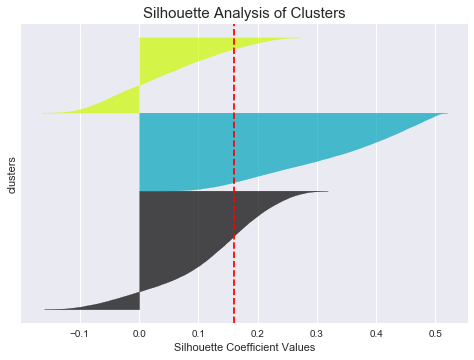

Wall time: 2min 30s


In [13]:
%%time
sample_silhouette_values = silhouette_samples(d2v_model.docvecs.vectors_docs, cluster_labels, metric='euclidean')

y_lower = 10

for i in range(n_clusters_):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    color = cm.nipy_spectral(float(i) / n_clusters_)
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,
                      facecolor=color,edgecolor=color, alpha=0.7)
    y_lower = y_upper + 10
    
silhouette_avg  = silhouette_score(d2v_model.docvecs.vectors_docs, cluster_labels)
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title('Silhouette Analysis of Clusters', fontsize = 15)
plt.ylabel('clusters')
plt.yticks([])
plt.xlabel('Silhouette Coefficient Values')
plt.show()

# Analyzing clusters

In [14]:
listed_products['group'] = cluster_labels
listed_products.order_id = listed_products.order_id.astype(int)
lp_expanded = listed_products.merge(order_products, on = 'order_id')
lp_expanded = lp_expanded.merge(products, on = 'product_id')

#seperating into groups
group_1 = lp_expanded[lp_expanded.group == 0]
group_2 = lp_expanded[lp_expanded.group == 1]
group_3 = lp_expanded[lp_expanded.group == 2]

#collecting top 5 product ids
group_1_t5 = group_1.product_id.value_counts()[:5]/len(group_1)
group_2_t5 = group_2.product_id.value_counts()[:5]/len(group_2)
group_3_t5 = group_3.product_id.value_counts()[:5]/len(group_3)

lp_expanded.head()

,order_id,products,group,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,110,"[organic, lemon, organic, unsweetened, almond,...",1,5876,1,0,Organic Lemon,24,4
1,3573,"[organic, baby, carrots, bag, of, organic, ban...",2,5876,20,1,Organic Lemon,24,4
2,3944,"[tofu, spring, roll, organic, spring, mix, org...",0,5876,3,1,Organic Lemon,24,4
3,9697,"[organic, hass, avocado, organic, gluten, free...",2,5876,7,0,Organic Lemon,24,4
4,14458,"[trilogy, kombucha, drink, organic, blackberri...",2,5876,4,0,Organic Lemon,24,4


## cart size by group

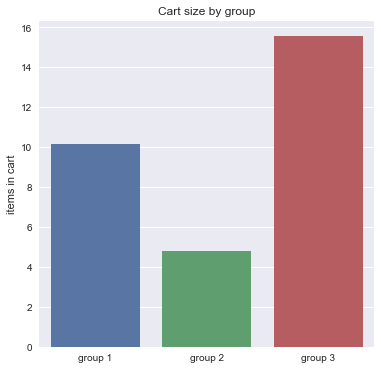

In [15]:
avg_cart_size_g1 = group_1.groupby('order_id').count().mean()[0]
avg_cart_size_g2 = group_2.groupby('order_id').count().mean()[0]
avg_cart_size_g3 = group_3.groupby('order_id').count().mean()[0]
avg_carts = [avg_cart_size_g1,avg_cart_size_g2,avg_cart_size_g3]

fig = plt.figure(figsize=(6, 6))
sns.barplot(x = ['group 1','group 2','group 3'],
            y = avg_carts)
plt.title('Cart size by group')
plt.ylabel('items in cart')
plt.show()

## Top departments for each group

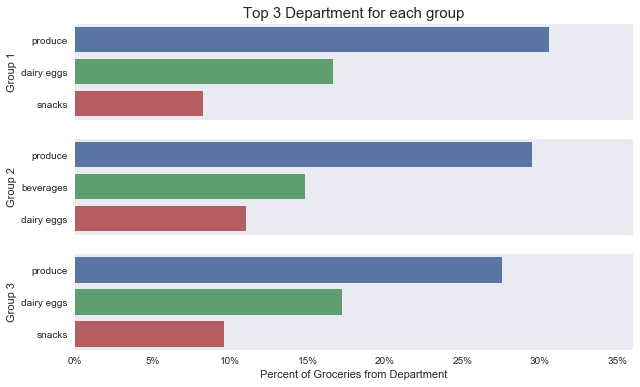

In [16]:
#group 1
t3_dept_g1_count = group_1.department_id.value_counts()[:3]/len(group_1.aisle_id)
t3_dept_g1 = departments[departments.department_id.isin(t3_dept_g1_count.index.to_list())].department

#group 2
t3_dept_g2_count = group_2.department_id.value_counts()[:3]/len(group_2.aisle_id)
t3_dept_g2 = departments[departments.department_id.isin(t3_dept_g2_count.index.to_list())].department

#group 3
t3_dept_g3_count = group_3.department_id.value_counts()[:3]/len(group_3.aisle_id)
t3_dept_g3 = departments[departments.department_id.isin(t3_dept_g3_count.index.to_list())].department

######## plotting ##########
fig = plt.figure(figsize=(10, 6))
range_low = 0
range_high = 0.36
#group 1
plt.subplot(311)
plt.title('Top 3 Department for each group', fontsize = 15)
g1 = sns.barplot(x = t3_dept_g1_count.tolist(), y = t3_dept_g1.tolist())
plt.ylabel('Group 1')
plt.xlim([range_low,range_high])
plt.xticks([])
#group2
plt.subplot(312)
g2 = sns.barplot(x = t3_dept_g2_count.tolist(), y = t3_dept_g2.tolist())
plt.ylabel('Group 2')
plt.xlim([range_low,range_high])
plt.xticks([])
#group3
plt.subplot(313)
g3 = sns.barplot(x = t3_dept_g3_count.tolist(), y = t3_dept_g3.tolist())
plt.ylabel('Group 3')
plt.xlabel('Percent of Groceries from Department')
plt.xlim([range_low,range_high])
g3.set_xticklabels(['{:,.0%}'.format(x) for x in g3.get_xticks()])
g3.grid(False)
plt.show()

## Top Aisles for each group

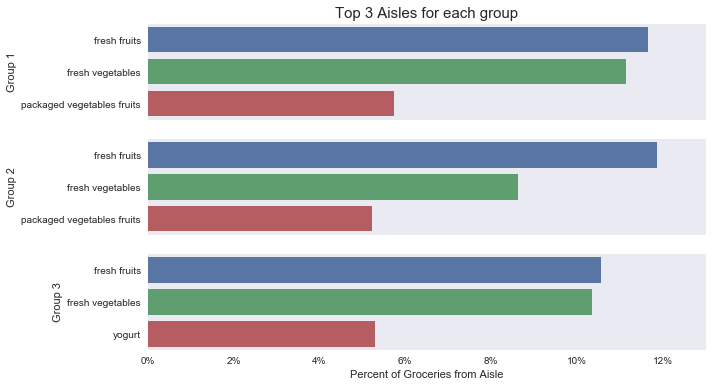

In [17]:
#group 1
t3_aisles_g1_count = group_1.aisle_id.value_counts()[:3]/len(group_1.aisle_id)
t3_aisles_g1 = aisles[aisles.aisle_id.isin(t3_aisles_g1_count.index.to_list())].aisle

#group 2
t3_aisles_g2_count = group_2.aisle_id.value_counts()[:3]/len(group_2.aisle_id)
t3_aisles_g2 = aisles[aisles.aisle_id.isin(t3_aisles_g2_count.index.to_list())].aisle

#group 3
t3_aisles_g3_count = group_3.aisle_id.value_counts()[:3]/len(group_3.aisle_id)
t3_aisles_g3 = aisles[aisles.aisle_id.isin(t3_aisles_g3_count.index.to_list())].aisle

######## plotting ##########
fig = plt.figure(figsize=(10, 6))
range_low = 0
range_high = 0.13
#group 1
plt.subplot(311)
plt.title('Top 3 Aisles for each group', fontsize = 15)
g1 = sns.barplot(x = t3_aisles_g1_count.tolist(), y = t3_aisles_g1.tolist())
plt.ylabel('Group 1')
plt.xlim([range_low,range_high])
plt.xticks([])
#group2
plt.subplot(312)
g2 = sns.barplot(x = t3_aisles_g2_count.tolist(), y = t3_aisles_g2.tolist())
plt.ylabel('Group 2')
plt.xlim([range_low,range_high])
plt.xticks([])
#group3
plt.subplot(313)
g3 = sns.barplot(x = t3_aisles_g3_count.tolist(), y = t3_aisles_g3.tolist())
plt.ylabel('Group 3')
plt.xlabel('Percent of Groceries from Aisle')
plt.xlim([range_low,range_high])
g3.set_xticklabels(['{:,.0%}'.format(x) for x in g3.get_xticks()])
g3.grid(False)
plt.show()

## top products in each cluster

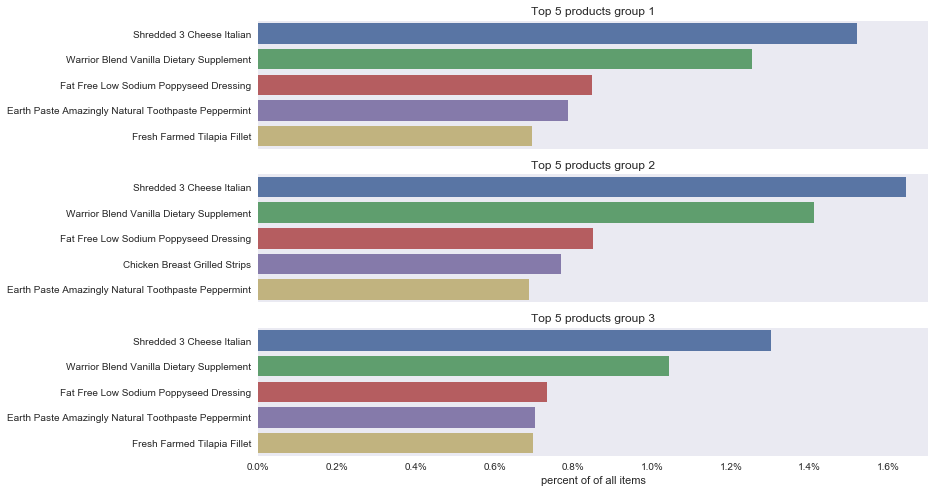

In [18]:
#### Ploting #######
fig = plt.figure(figsize=(12, 8))

range_low = 0
range_high = 0.017

#group 1 top 5 products
plt.subplot(311)
g1_top_products = products.iloc[group_1_t5.index.to_list()]
g1 = sns.barplot(x = group_1_t5, y = g1_top_products.product_name)
plt.title('Top 5 products group 1')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.xlim([range_low,range_high])


#group 2 top 5 products
plt.subplot(312)
g2_top_products = products.iloc[group_2_t5.index.to_list()]
g2 = sns.barplot(x = group_2_t5, y = g2_top_products.product_name)
plt.title('Top 5 products group 2')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.xlim([range_low,range_high])

#group 3 top 5 products
plt.subplot(313)
g3_top_products = products.iloc[group_3_t5.index.to_list()]
g3 = sns.barplot(x = group_3_t5, y = g3_top_products.product_name)
plt.title('Top 5 products group 3')
plt.ylabel('')
plt.xlabel('percent of of all items')
plt.xlim([range_low,range_high])

g3.set_xticklabels(['{:,.1%}'.format(x) for x in g3.get_xticks()])

plt.grid(False)

plt.show()

---